# Exercise #1: Molecular dynamics of NaCl

In this exercise, we will perform our first molecular dynamics simulation. We will rely on the following software:
- [OpenMM](https://openmm.org/) as a molecular simulation engine, to perform the MD itself ([documentation](https://docs.openmm.org/latest/userguide/index.html))
- [MDAnalysis](https://www.mdanalysis.org/) to analyze some of the molecular properties ([documentation](https://userguide.mdanalysis.org/stable/index.html))
- [nglview](https://github.com/nglviewer/nglview) for the visualization of structures ([documentation](https://nglviewer.org/nglview/latest/))

We will also use the following scientific Python libraries: NumPY (for numerical data), Panda (data handling and statistics), and Seaborn (plotting). You can find some help and documentation about them below:
- [NumPy: the absolute basics for beginners](https://numpy.org/doc/stable/user/absolute_beginners.html)
- [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
- [An introduction to seaborn](https://seaborn.pydata.org/tutorial/introduction.html)

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
# Install required packages if running on Google Colab
!pip install mdanalysis nglview openmm

In [2]:
from io import StringIO

import numpy as np
import pandas as pd

import MDAnalysis as mda
import nglview

import openmm
import openmm.app
import openmm.unit

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False

OK, let's have a look at the system I have chosen for this exercise. It's a structure of sodium chloride, stored in a file with PDB format. The file is called `NaCl_4x4x4.pdb`, and we can view its chemical structure with the `nglview.show_file()` function.

In [3]:
nglview.show_file('NaCl_4x4x4.pdb')

NGLWidget()

I find the perspective of the representation distracting, so I'd rather use what is called an “orthographic projection”. Also, let's remember we are studying a periodic system, so we will plot the box of the system. If you want to explore more options for visualization, you can use the [full NGL Viewer web app](https://nglviewer.org/ngl/) at https://nglviewer.org/ngl/

In [4]:
view = nglview.show_file('NaCl_4x4x4.pdb')
view.camera = 'orthographic'
view.add_unitcell()
view

NGLWidget()

Can you recognise the crystal type of NaCl, and **how many unit cells are present in this simulation box?** A bit more difficult, **why are we choosing to perform MD on a larger supercell**, instead of the unit cell.

It's also interesting to consider for a moment what information is in the PDB file, and how it is stored. A PDB file is a simple text file, so you can open it with a text editor (Notepad app or other), or we can simply display its first 12 lines below.

In [5]:
with open('NaCl_4x4x4.pdb', 'r') as f:
    content = f.readlines()
    print(''.join(content[:12]))

HEADER    Halite - NaCl    
CRYST1   22.520   22.520   22.520  90.00  90.00  90.00 P 1
SCALE1      0.044405  0.000000  0.000000        0.00000
SCALE2      0.000000  0.044405  0.000000        0.00000
SCALE3      0.000000  0.000000  0.044405        0.00000
ATOM      1 Cl   MOL H   1       2.815   0.000   0.000  1.00  0.00          Cl0 
ATOM      2 Cl   MOL H   2       2.815   0.000   5.630  1.00  0.00          Cl0 
ATOM      3 Cl   MOL H   3       2.815   0.000  11.260  1.00  0.00          Cl0 
ATOM      4 Cl   MOL H   4       2.815   0.000  16.890  1.00  0.00          Cl0 
ATOM      5 Cl   MOL H   5       2.815   5.630   0.000  1.00  0.00          Cl0 
ATOM      6 Cl   MOL H   6       2.815   5.630   5.630  1.00  0.00          Cl0 
ATOM      7 Cl   MOL H   7       2.815   5.630  11.260  1.00  0.00          Cl0 



**Can you figure out what information is present?** You can get help from the [PDB format documentation](https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html) if you want to understand what all these numbers are.

## Representing interactions in the system: the force field

OK, so we have chosen the system we want to study, and we have a structure that should be suitable as an initial configuration for our molecular dynamics simulation. The next piece of information we need is how we will represent the interactions between atoms in the system.

We are going to perform MD simulations with a classical force field, because it is the only level of accuracy that is fast enough for us to study realistic systems on a single computer in the limited time available. Evaluating interactions through DFT (in what is called _ab initio_ MD or DFT-MD) would require much larger resources.

So, we need to represent the interactions in the system through a classical force field. NaCl being such a common system, we can easily find a lot of force fields for it. We'll go with a simple, nonbonded model, where each Na and Cl atom is a force center, and they interact through:
- electrostatic interactions represented by Coulomb's law:
$$ E_{\text{Coulomb}}(r_{ij}) = \frac{1}{4\pi\varepsilon_0} \frac{q_i q_j}{r_{ij}} $$
- repulsive and dispersive interactions (van der Waals forces), represented by the Lennard–Jones potential:
$$ E_{\text{LJ}}(r_{ij}) = 4\varepsilon_{ij} \left(\frac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left(\frac{\sigma_{ij}}{r_{ij}}\right)^6 $$

In total, **how many parameters are required to parameterize this force field?** Searching the web, can you find existing examples of force fields that would be adapted for NaCl?

In [6]:
# OpenMM has many ways to build and represent force fields. Here, we will use its XML format,
# which is documented here: https://docs.openmm.org/latest/userguide/application/06_creating_ffs.html
# It has a specific type of force for Coulombic + LJ interactions, as it is very common:
# https://docs.openmm.org/latest/userguide/application/06_creating_ffs.html#nonbondedforce

# We have to be careful about units:
#  - mass is in atomic mass units (daltons)
#  - charge is in units of the proton charge
#  - sigma is in nm
#  - epsilon is in kJ/mole

offxml = """
<ForceField>
<AtomTypes>
 <Type name="0" class="Na" element="Na" mass="22.990"/>
 <Type name="1" class="Cl" element="Cl" mass="35.453"/>
</AtomTypes>

<Residues>
 <Residue name="Na">
  <Atom name="Na" type="0"/>
 </Residue>
 <Residue name="Cl">
  <Atom name="Cl" type="1"/>
 </Residue>
</Residues>

<NonbondedForce coulomb14scale="0.0" lj14scale="0.0">
 <Atom type="0" charge="1.0" sigma="0.3330" epsilon="0.011598"/>
 <Atom type="1" charge="-1.0" sigma="0.4417" epsilon="0.493712"/>
</NonbondedForce>
</ForceField>
"""

forcefield = openmm.app.forcefield.ForceField(StringIO(offxml))

In the cell below, we extend the functionality of OpenMM for reporting quantities during the simulation, and include the pressure. You do not need to understand this in detail.

In [7]:
class ExtendedStateDataReporter(openmm.app.StateDataReporter):
    """
    An extension of OpenMM's StateDataReporter_ class, which also outputs pressure if a barostat is present
    """
    # Inspired by https://atomsmm.readthedocs.io/en/latest/_modules/atomsmm/reporters.html#ExtendedStateDataReporter
    # See also https://github.com/openmm/openmm/issues/5129
    def __init__(self, file, reportInterval, **kwargs):
        self._barostat = kwargs.pop('barostat', None)
        super().__init__(file, reportInterval, **kwargs)

    def _constructHeaders(self):
        headers = super()._constructHeaders()
        if self._barostat:
            headers.append('Pressure (atm)')
        return headers

    def _constructReportValues(self, simulation, state):
        values = super()._constructReportValues(simulation, state)
        if self._barostat:
            pressure = self._barostat.computeCurrentPressure(simulation.context)
            values.append(pressure.value_in_unit(openmm.unit.atmospheres))
        return values

## Initialize the simulation

The next cell contains the entire set up and initialization of our molecular dynamics simulation. It contains several parts:
1. Load the initial configuration and apply the force field. The software will look up the atom types in the force field, and identifies the corresponding atoms in the simulation box.
2. In order to perform MD in the $(N, P, T)$ ensemble, which is our goal here, we need to add to the simulation a thermostat and a barostat.
    - Assign variables for important parameters: timestep, temperature, pressure, etc.
    - Add a barostat to our simulation, ensuring we have fixed-pressure conditions (and therefore a variable volume of the unit cell)
    - Chose a way to integrate the equations of motion. We use here a so-called [Langevin integrator](https://en.wikipedia.org/wiki/Langevin_dynamics), which combines the integration of Newton's law with a thermostat, ensuring we have a fixed-temperature dynamics.
3. Decide what output data we want from our simulation. We will write 3 files:
    - atomic positions in PDB format (creating a “movie” of our trajectory)
    - atomic positions in another format, called DCD (more compact, we will use it later)
    - tabular data in a CSV (coma-separate values) file: time, energy, temperature, pressure, volume, density, etc.

In [8]:
# PART 1
# Load the initial structure
pdb = openmm.app.pdbfile.PDBFile('NaCl_4x4x4.pdb')

# Check that the force field covers all atom types in the input structure
unmatched_residues = forcefield.getUnmatchedResidues(pdb.topology)
assert len(unmatched_residues) == 0

# Assign the force field 
system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffPeriodic,
                                 nonbondedCutoff=11. * openmm.unit.angstrom)

# PART 2
# Values of important parameters for our simulation
step = 0.001 * openmm.unit.picoseconds
temp = 800. * openmm.unit.kelvin
press = 0. * openmm.unit.bar
friction = 1. / openmm.unit.picoseconds

# Add a barostat, to simulate a fixed-pressure system
barostat = openmm.MonteCarloBarostat(press, temp)
system.addForce(barostat)

# Integrate equations of motion following the Langevin dynamics, with fixed-temperature
integrator = openmm.LangevinMiddleIntegrator(temp, friction, step)
simulation = openmm.app.Simulation(pdb.topology, system, integrator)

# PART 3
# Output atomic positions in PDB and DCD files
pdb_reporter = openmm.app.PDBReporter("md_trajectory.pdb", 20, enforcePeriodicBox=False)
simulation.reporters.append(pdb_reporter)
dcd_reporter = openmm.app.DCDReporter("md_trajectory.dcd", 20, enforcePeriodicBox=False)
simulation.reporters.append(dcd_reporter)

# Write out tabular data
data_reporter = ExtendedStateDataReporter("md_data.csv", 20,
    step=True, time=True, potentialEnergy=True, kineticEnergy=True,
    volume=True, temperature=True, density=True, barostat=barostat,
)
simulation.reporters.append(data_reporter)

We are ready to go! Now we can perform the simulation itself, we will follow three steps:
1. Make sure all particles are in their initial configuration
2. Relax them to minimize the energy
3. Draw random initial velocities from a [Maxwell–Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution) consistent with our target temperature
4. Run a fixed number of MD steps

The second step is important because we want to start close to the equilibrium structure for the model, and the experimental initial configuration may be somewhat different. Therefore, it's good practice to find a local energy minimum of our model before performing MD.

In [9]:
%%time

simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temp)
simulation.step(10000)

CPU times: user 1.24 s, sys: 621 ms, total: 1.86 s
Wall time: 2.59 s


🎉 Ta-da! Molecular simulation completed.

## Viewing the MD trajectory

We are going to view the MD trajectory, i.e., the evolution of the position of all atoms over time. We have written one “frame” every 50 time steps, so frames are separated by 50 fs each. We use the [MDAnalysis](https://www.mdanalysis.org/) package to read the coordinate from the file in DCD format and load them in memory:

In [10]:
trajectory = mda.Universe('NaCl_4x4x4.pdb', 'md_trajectory.dcd')
trajectory.transfer_to_memory()

/Users/fx/miniforge3/envs/ML2025b/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [11]:
view = nglview.show_mdanalysis(trajectory)
view.camera = 'orthographic'
# The simulation box does not increase in the viewer, due to a bug
# https://github.com/nglviewer/nglview/issues/1173
# So we won't display it
# view.add_unitcell()
view

NGLWidget(max_frame=499)

**What observations about the system can you make from this trajectory?**

## Analyzing the data from MD

Our simulation has output a lot of information in the `md_data.csv` file. Let's extract it and see how we can analyze it. The CSV file format can be read by the pandas library, and loaded directly into a nice table with headers.

In [12]:
data = pd.read_csv("md_data.csv")
data

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Kinetic Energy (kJ/mole),Temperature (K),Box Volume (nm^3),Density (g/mL),Pressure (atm)
0,20,0.02,-150956.635084,2306.601074,361.931302,11.421027,2.175286,58234.561781
1,40,0.04,-150257.191725,1627.874023,255.431497,11.421027,2.175286,59629.177447
2,60,0.06,-151216.029127,2729.738281,428.326225,11.421027,2.175286,54123.691609
3,80,0.08,-151199.047637,2667.708496,418.593064,11.451872,2.169427,53465.882379
4,100,0.10,-151409.278350,2887.209473,453.035203,11.451872,2.169427,53011.591954
...,...,...,...,...,...,...,...,...
495,9920,9.92,-149492.825575,5219.581543,819.010260,12.420445,2.000251,-876.822852
496,9940,9.94,-149358.149306,5168.935547,811.063342,12.420445,2.000251,200.508290
497,9960,9.96,-149046.326261,4912.203125,770.779176,12.457721,1.994265,-634.170886
498,9980,9.98,-149226.429453,5010.349121,786.179372,12.406408,2.002514,1199.501976


In [13]:
data.describe()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Kinetic Energy (kJ/mole),Temperature (K),Box Volume (nm^3),Density (g/mL),Pressure (atm)
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,5010.000000,5.010000,-149413.699176,4797.071014,752.713670,12.387241,2.006162,2091.578962
std,2889.636655,2.889637,624.516175,575.746570,90.341025,0.199723,0.034194,9955.297537
min,20.000000,0.020000,-151544.538848,1627.874023,255.431497,11.421027,1.968196,-7943.285846
25%,2515.000000,2.515000,-149493.224725,4731.867432,742.482505,12.390075,1.991868,-1818.384386
50%,5010.000000,5.010000,-149240.382784,4967.329102,779.429053,12.433534,1.998145,-135.582143
75%,7505.000000,7.505000,-149029.022832,5121.948608,803.690570,12.472713,2.005154,1729.584428
max,10000.000000,10.000000,-148565.660319,5570.019043,873.997792,12.622725,2.175286,59629.177447


The most commmon way to visualize this information is to plot evolution of simulated quantities over time.

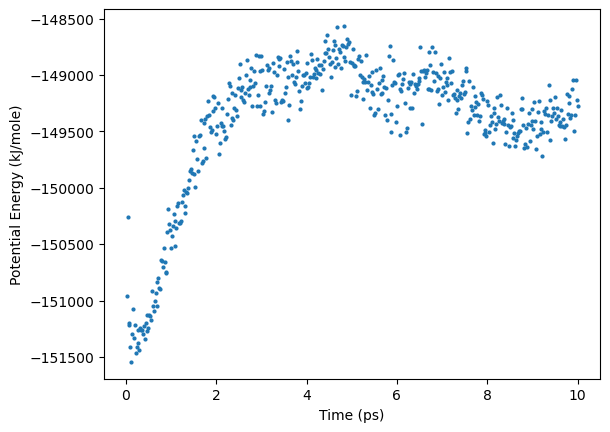

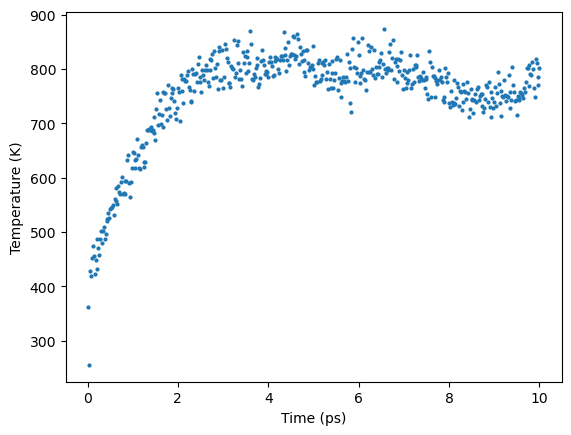

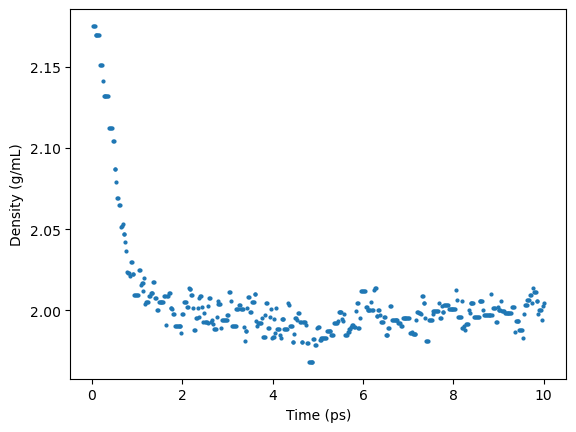

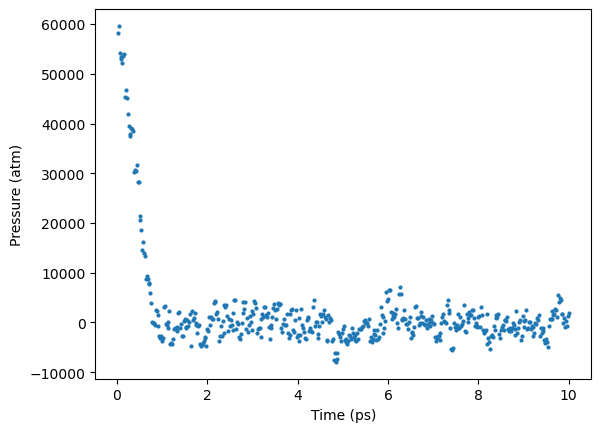

In [14]:
data.plot.scatter(x='Time (ps)', y='Potential Energy (kJ/mole)', s=4);
data.plot.scatter(x='Time (ps)', y='Temperature (K)', s=4);
data.plot.scatter(x='Time (ps)', y='Density (g/mL)', s=4);
data.plot.scatter(x='Time (ps)', y='Pressure (atm)', s=4);

## What next?

You have above all the necessary code to run a MD simulation, and display numerical results. Let's see what you can do with it! Here are some questions for you to answer:

1. Equilibration
2. Influence of the thermostat
3. Influence of the barostat
4. Effect of system size